In [1]:
import wikipedia, requests, random, pycm, json, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from IPython.display import display, Markdown
from classification_procedure import ClassificationProcedure

## Classification procedures

In [2]:
oed_planet = ClassificationProcedure(
    "OED",
    "planet", 
    """Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).""",
    "https://www.oed.com/dictionary/planet_n"
)

iau_2006_8_16_planet = ClassificationProcedure(
    "IAU 2006-08-16",
    "planet", 
    """A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.""",
    "https://www.iau.org/news/pressreleases/detail/iau0601/"
)

iau_2006_8_24_planet = ClassificationProcedure(
    "IAU 2006-08-24",
    "planet", 
    """A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.""",
    "https://www.iau.org/static/resolutions/Resolution_GA26-5-6.pdf"
)

### Example in Figure 1

In [3]:
iau_2006_8_24_planet.classify("DENIS-P J082303.1−491201 b", "DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.")

{'concept': 'planet',
 'definition': 'A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient \nmass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic \nequilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.',
 'entity': 'DENIS-P J082303.1−491201 b',
 'description': 'DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.',
 'rationale': 'The description of DENIS-P J082303.1−491201 b indicates that it is a substellar object that orbits DENIS-P J082303.1-491201, which is a brown dwarf. This aligns with the first part of the definition of a planet, which states that a planet is a celestial body that is in orbit around the Sun. However, in this case, DENIS-P J082303.1−491201 b is orbiting a brown dwarf, not the Sun. Therefo

## Wikidata queries

In [4]:
KNOWLEDGE_GRAPH = "https://query.wikidata.org/sparql"

QUERY_HEADERS = {
    'User-Agent': 'ConceptualEngineeringAgent/0.2 (https://github.com/bradleypallen/conceptual-engineering-using-llms; b.p.allen@uva.nl)',
}

SAMPLE_SIZE = 50

POSITIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q634 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
  }
} LIMIT 10000"""

NEGATIVE_EXAMPLES_QUERY = """SELECT DISTINCT ?entity ?name ?article WHERE {
  {
    ?entity p:P31/ps:P31/wdt:P279* wd:Q3132741 .
    ?article schema:about ?entity ;
            schema:inLanguage "en" ;
            schema:isPartOf <https://en.wikipedia.org/> ;
            schema:name ?name .
    FILTER NOT EXISTS { ?entity p:P31/ps:P31 wd:Q634 }
  }
} LIMIT 10000"""

## Example entities

In [5]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : POSITIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
positive_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
positive_examples["description"] = positive_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
positive_examples["actual"] = "positive"

In [6]:
response = requests.get(KNOWLEDGE_GRAPH, params={'query' : NEGATIVE_EXAMPLES_QUERY, 'format' : 'json'}, headers=QUERY_HEADERS)
response.raise_for_status()
json_response = response.json()
records = [ [ result["entity"]["value"], result["name"]["value"], result["article"]["value"] ] for result in json_response["results"]["bindings"] ]
records = random.sample(records, SAMPLE_SIZE)
negative_examples = pd.DataFrame.from_records(records, columns=["id", "name", "article"])
negative_examples["description"] = negative_examples["name"].apply(lambda name: wikipedia.summary(name, auto_suggest=False).replace('"', r'\"').strip()) 
negative_examples["actual"] = "negative"

In [7]:
examples = pd.concat([positive_examples, negative_examples], ignore_index=True)
examples

,id,name,article,description,actual
0,http://www.wikidata.org/entity/Q1072379,Mu Arae d,https://en.wikipedia.org/wiki/Mu_Arae_d,"Mu Arae d, also known as HD 160691 d, formally...",positive
1,http://www.wikidata.org/entity/Q83770,HD 82943 c,https://en.wikipedia.org/wiki/HD_82943_c,HD 82943 c is an extrasolar planet approximate...,positive
2,http://www.wikidata.org/entity/Q2668671,Kepler-9c,https://en.wikipedia.org/wiki/Kepler-9c,Kepler-9c is one of the first seven extrasolar...,positive
3,http://www.wikidata.org/entity/Q15120420,Kepler-46b,https://en.wikipedia.org/wiki/Kepler-46b,"Kepler-46, previously designated KOI-872, is a...",positive
4,http://www.wikidata.org/entity/Q117422669,KMT-2022-BLG-0440L b,https://en.wikipedia.org/wiki/KMT-2022-BLG-044...,KMT-2022-BLG-0440L b is a Neptune-like exoplan...,positive
...,...,...,...,...,...
95,http://www.wikidata.org/entity/Q28502877,Kepler-167c,https://en.wikipedia.org/wiki/Kepler-167c,Kepler-167 is a K-type main-sequence star loca...,negative
96,http://www.wikidata.org/entity/Q838179,Salyut 2,https://en.wikipedia.org/wiki/Salyut_2,Salyut 2 (OPS-1) (Russian: Салют-2 meaning Sal...,negative
97,http://www.wikidata.org/entity/Q6586357,28723 Cameronjones,https://en.wikipedia.org/wiki/28723_Cameronjones,The following is a partial list of minor plane...,negative
98,http://www.wikidata.org/entity/Q93464183,Tau Ceti h,https://en.wikipedia.org/wiki/Tau_Ceti_h,"Tau Ceti, Latinized from τ Ceti, is a single s...",negative


## Experiments

In [8]:
def run_experiment(cp, examples):
    classifications = examples.to_dict("records")
    for entity in tqdm(classifications):
        classification = cp.classify(entity["name"], entity["description"])
        entity["rationale"] = classification["rationale"]
        entity["predicted"] = classification["answer"]
    return pd.DataFrame.from_records(classifications)

In [9]:
oed_planet_results = run_experiment(oed_planet, examples)

100%|██████████| 100/100 [11:17<00:00,  6.78s/it]


In [10]:
iau_2006_8_16_planet_results = run_experiment(iau_2006_8_16_planet, examples)

100%|██████████| 100/100 [37:18<00:00, 22.38s/it]  


In [11]:
iau_2006_8_24_planet_results = run_experiment(iau_2006_8_24_planet, examples)

100%|██████████| 100/100 [1:17:30<00:00, 46.50s/it]  


## Performance metrics

In [12]:
oed_planet_cm = pycm.ConfusionMatrix(
    oed_planet_results["actual"].tolist(), 
    oed_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_16_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_16_planet_results["actual"].tolist(), 
    iau_2006_8_16_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

iau_2006_8_24_planet_cm = pycm.ConfusionMatrix(
    iau_2006_8_24_planet_results["actual"].tolist(), 
    iau_2006_8_24_planet_results["predicted"].tolist(), 
    digit=2, 
    classes=[ 'positive', 'negative' ]
)

In [13]:
cms = [
    (f'{oed_planet.term} ({oed_planet.id})', oed_planet_cm),
    (f'{iau_2006_8_16_planet.term} ({iau_2006_8_16_planet.id})', iau_2006_8_16_planet_cm),
    (f'{iau_2006_8_24_planet.term} ({iau_2006_8_24_planet.id})', iau_2006_8_24_planet_cm)
]

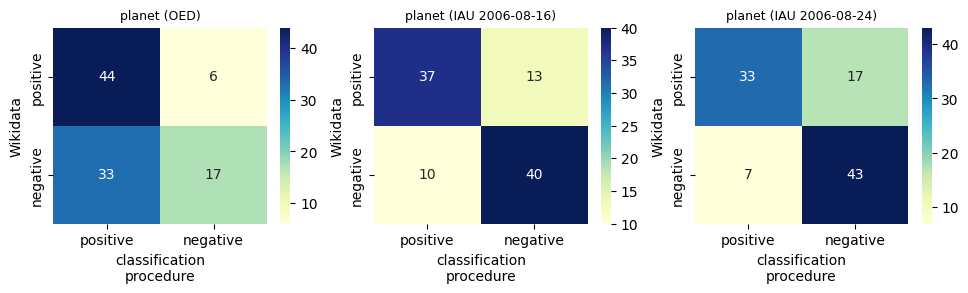

In [14]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='classification\nprocedure', ylabel='Wikidata')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

In [15]:
metrics = pd.DataFrame.from_records([ 
    { "classification procedure": cm[0], "Cohen's kappa": cm[1].Kappa, "F1 macro": cm[1].F1_Macro, "FN": cm[1].FN["positive"], "FP": cm[1].FP["positive"] }
    for cm in cms 
])
metrics.sort_values(by="Cohen's kappa", ascending=False)

,classification procedure,Cohen's kappa,F1 macro,FN,FP
1,planet (IAU 2006-08-16),0.54,0.769793,13,10
2,planet (IAU 2006-08-24),0.52,0.757576,17,7
0,planet (OED),0.22,0.579333,6,33


## Error analyses

In [16]:
def display_errors(cp, results):
    display(Markdown(f'### {cp.term} ({cp.id})'))
    display(Markdown(f'#### Definition'))
    display(Markdown(f'{cp.definition}'))
    fns = results[((results["actual"] == 'positive') & (results["predicted"] == 'negative'))][["name", "description", "rationale"]]
    if len(fns) > 0:
        fns_styler = fns.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False negatives'))
        display(fns_styler)
    fps = results[((results["actual"] == 'negative') & (results["predicted"] == 'positive'))][["name", "description", "rationale"]]
    if len(fps) > 0:
        fps_styler = fps.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown(f'#### False positives'))
        display(fps_styler)


In [17]:
display_errors(oed_planet, oed_planet_results)

### planet (OED)

#### Definition

Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits 
around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, 
Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing 
distance from the sun); a similar body revolving around another star. Also: any of various 
smaller bodies that revolve around these (cf. satellite n. 2a).

#### False negatives

name,description,rationale
Beta Ursae Minoris b,"Kochab , Bayer designation Beta Ursae Minoris (β Ursae Minoris, abbreviated β UMi, Beta UMi), is the brightest star in the bowl of the Little Dipper asterism (which is part of the constellation of Ursa Minor), and only slightly fainter than Polaris, the northern pole star and brightest star in Ursa Minor. Kochab is 16 degrees from Polaris and has an apparent visual magnitude of 2.08. The distance to this star from the Sun can be deduced from the parallax measurements made during the Hipparcos mission, yielding a value of 130.9 light-years (40.1 parsecs).Amateur astronomers can use Kochab as a precise guide for equatorial mount alignment: The celestial north pole is located 38 arcminutes away from Polaris, very close to the line connecting Polaris with Kochab.","The provided description does not provide sufficient information to assert that Beta Ursae Minoris b is a planet. The description primarily discusses Kochab, a star, and its characteristics such as its brightness, distance from the Sun, and its use for astronomers. There is no mention of Beta Ursae Minoris b revolving in an elliptical orbit around a star, being visible by reflected light, or any other characteristics that would classify it as a planet according to the provided definition. Therefore, based on the given information, we cannot argue that Beta Ursae Minoris b is a planet."
WASP-57b,"WASP-57 is a single G-type main-sequence star about 1310 light-years away. WASP-57 is depleted in heavy elements, having 55% of the solar abundance of iron. WASP-57 is much younger than the Sun at 0.957±0.518 billion years.A multiplicity survey in 2015 did not detect any stellar companions to WASP-57.","The definition of a planet includes any body that revolves in an elliptical orbit around a star and is visible by its reflected light. While the description of WASP-57b does not explicitly state that it revolves around a star, it is implied by the name WASP-57b, as this naming convention is typically used for planets and their host stars. Furthermore, the description mentions that WASP-57 is a star and that a survey did not detect any stellar companions, suggesting that WASP-57b is not a star but a different type of celestial body. Therefore, it can be inferred that WASP-57b is a planet."
HD 86226 c,"HD 86226 is a G-type yellowish white star found in the constellation of Hydra. A survey in 2015 has ruled out the existence of any stellar companions at projected distances above 12 astronomical units.Radio emission at a frequency of 150 MHz has been tentatively detected from the proximity of this system, although it is not clear whether the star or a satellite orbiting a rapidly rotating planet is the source.","The definition of a planet includes any body that revolves in approximately elliptical orbits around the sun or another star and is visible by its reflected light. While the description of HD 86226 c does not explicitly state that it is a planet, it does mention that it is a body found in the constellation of Hydra and that it may have a satellite orbiting it. The presence of a satellite suggests that HD 86226 c is a body with significant gravitational pull, which is a characteristic of a planet. Therefore, based on the provided definition, it can be argued that HD 86226 c is a planet."
HD 79498 b,HD 79498 is a primary of the star system located 159 light years away in the constellation Cancer. This G5 main sequence star has an apparent magnitude of 8.0 and is about the same size and mass as the Sun. It has a higher than solar abundance of elements other than hydrogen and helium; what astronomers term a metal-rich star.The secondary star of the star system is the BD+23 2063 B located on the projected separation of the 2900 AU from the primary. It is a red dwarf of spectral class M0.,"The concept definition of a planet states that it is a body that revolves in approximately elliptical orbits around the sun or a similar body revo

#### False positives

name,description,rationale
PSR B1620−26 b,"PSR B1620−26 b is an exoplanet located approximately 12,400 light-years from Earth in the constellation of Scorpius. It bears the unofficial nicknames \""Methuselah\"" and \""the Genesis planet\"" (named after the Biblical character Methuselah, who, according to the Bible, lived to be the oldest person) due to its extreme age. The planet is in a circumbinary orbit around the two stars of PSR B1620−26 (which are a pulsar (PSR B1620−26 A) and a white dwarf (WD B1620-26)) and is the first circumbinary planet ever confirmed. It is also the first planet found in a globular cluster. The planet is one of the oldest known extrasolar planets, believed to be about 12.7 billion years old.","PSR B1620−26 b fits the definition of a planet as it is a body that revolves in an orbit around two stars, PSR B1620−26 A and WD B1620-26, similar to how planets in our solar system revolve around the sun. It is also visible by the reflected light of its stars. Furthermore, it is an exoplanet, which is a term used to describe a planet that orbits a star outside the solar system, fitting the part of the definition that includes similar bodies revolving around other stars. Therefore, based on the provided definition, PSR B1620−26 b can be classified as a planet."
K2-33b,"K2-33b (also known by its EPIC designation EPIC 205117205.01) is a very young super-Neptune exoplanet, orbiting the pre-main-sequence star K2-33. It was discovered by NASA's Kepler spacecraft on its \""Second Light\"" mission. It is located about 456 light-years (140 parsecs) away from Earth in the constellation of Scorpius. The exoplanet was found by using the transit method, in which the dimming effect that a planet causes as it crosses in front of its star is measured. Among known exoplanets, K2-33b is considered extremely young − a mere 9.3 million years old. Only one other exoplanet is younger, with an age of 2 Myr (V830 Tau b).","K2-33b fits the definition of a planet as it is a body that revolves around a star, in this case, the pre-main-sequence star K2-33. It was discovered using the transit method, which measures the dimming effect a planet causes as it crosses in front of its star, further supporting its classification as a planet. Additionally, it is referred to as an exoplanet, which is a term used to describe planets that orbit a star outside of our solar system, aligning with the part of the definition that includes bodies revolving around other stars. Therefore, based on the provided definition, K2-33b can be classified as a planet."
5821 Yukiomaeda,"The following is a partial list of minor planets, running from minor-planet number 5001 through 6000, inclusive. The primary data for this and other partial lists is based on JPL's \""Small-Body Orbital Elements\"" and \""Data Available from the Minor Planet Center\"". A detailed description of the table's columns and additional sources are given on the main page including a complete list of every page in this series, and a statistical break-up on the dynamical classification of minor planets. Also see the summary list of all named bodies in numerical and alphabetical order, and the corresponding naming citations for the number range of this particular list. New namings may only be added to this list after official publication, as the preannouncement of names is condemned by the Working Group for Small Bodies Nomenclature of the International Astronomical Union.","The definition of a planet includes any of various smaller bodies that revolve around larger bodies such as the sun. The description of 5821 Yukiomaeda indicates that it is a minor planet, which falls under the category of smaller bodies. Therefore, based on the provided definition, one could argue that 5821 Yukiomaeda is a planet."
37392 Yukiniall,"The following is a partial list of minor planets, running from minor-planet number 37001 through 38000, inclusive. The primary data for this and other partial lists is based on

In [18]:
display_errors(iau_2006_8_16_planet, iau_2006_8_16_planet_results)

### planet (IAU 2006-08-16)

#### Definition

A planet is a celestial body that (a) has sufficient mass for its self-gravity to 
overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, 
and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.

#### False negatives

name,description,rationale
Beta Ursae Minoris b,"Kochab , Bayer designation Beta Ursae Minoris (β Ursae Minoris, abbreviated β UMi, Beta UMi), is the brightest star in the bowl of the Little Dipper asterism (which is part of the constellation of Ursa Minor), and only slightly fainter than Polaris, the northern pole star and brightest star in Ursa Minor. Kochab is 16 degrees from Polaris and has an apparent visual magnitude of 2.08. The distance to this star from the Sun can be deduced from the parallax measurements made during the Hipparcos mission, yielding a value of 130.9 light-years (40.1 parsecs).Amateur astronomers can use Kochab as a precise guide for equatorial mount alignment: The celestial north pole is located 38 arcminutes away from Polaris, very close to the line connecting Polaris with Kochab.","The provided description does not provide sufficient information to assert that Beta Ursae Minoris b is a planet. The description primarily focuses on the characteristics of the star Kochab, not a celestial body orbiting it. There is no mention of Beta Ursae Minoris b's shape, its orbit around a star, or whether it is a star or a satellite of a planet. Therefore, based on the given definition and the provided information, we cannot argue that Beta Ursae Minoris b is a planet."
WASP-57b,"WASP-57 is a single G-type main-sequence star about 1310 light-years away. WASP-57 is depleted in heavy elements, having 55% of the solar abundance of iron. WASP-57 is much younger than the Sun at 0.957±0.518 billion years.A multiplicity survey in 2015 did not detect any stellar companions to WASP-57.","The provided description does not provide sufficient information to assert that WASP-57b is a planet. The description only provides information about the star WASP-57, not about any celestial bodies orbiting it. To determine if WASP-57b is a planet, we would need information confirming that it is a celestial body in orbit around WASP-57, that it has sufficient mass to assume a nearly round shape due to its self-gravity, and that it is not a star or a satellite of another planet."
HD 86226 c,"HD 86226 is a G-type yellowish white star found in the constellation of Hydra. A survey in 2015 has ruled out the existence of any stellar companions at projected distances above 12 astronomical units.Radio emission at a frequency of 150 MHz has been tentatively detected from the proximity of this system, although it is not clear whether the star or a satellite orbiting a rapidly rotating planet is the source.","The description of HD 86226 c does not provide sufficient information to definitively assert that it is a planet based on the provided definition. The description mentions that HD 86226 is a star and that there may be a satellite orbiting a rapidly rotating planet in the system, but it does not specify whether HD 86226 c is that potential planet or another celestial body. Furthermore, the description does not provide information about HD 86226 c's mass, shape, or whether it is in orbit around a star, which are all necessary criteria for a celestial body to be considered a planet according to the provided definition. Therefore, based on the information given, we cannot definitively assert that HD 86226 c is a planet."
HD 79498 b,HD 79498 is a primary of the star system located 159 light years away in the constellation Cancer. This G5 main sequence star has an apparent magnitude of 8.0 and is about the same size and mass as the Sun. It has a higher than solar abundance of elements other than hydrogen and helium; what astronomers term a metal-rich star.The secondary star of the star system is the BD+23 2063 B located on the projected separation of the 2900 AU from the primary. It is a red dwarf of spectral class M0.,"The provided description does not provide enough information to definitively assert that HD 79498 b is a planet. The description mentions that HD 79498 is a star system with a primary star and a secondary star, but it does not provide 

#### False positives

name,description,rationale
PSR B1620−26 b,"PSR B1620−26 b is an exoplanet located approximately 12,400 light-years from Earth in the constellation of Scorpius. It bears the unofficial nicknames \""Methuselah\"" and \""the Genesis planet\"" (named after the Biblical character Methuselah, who, according to the Bible, lived to be the oldest person) due to its extreme age. The planet is in a circumbinary orbit around the two stars of PSR B1620−26 (which are a pulsar (PSR B1620−26 A) and a white dwarf (WD B1620-26)) and is the first circumbinary planet ever confirmed. It is also the first planet found in a globular cluster. The planet is one of the oldest known extrasolar planets, believed to be about 12.7 billion years old.","PSR B1620−26 b can be classified as a planet based on the provided definition. Firstly, it is a celestial body that has a nearly round shape, indicating that it has sufficient mass for its self-gravity to overcome rigid body forces and achieve hydrostatic equilibrium. Secondly, it is in orbit around two stars, PSR B1620−26 A and WD B1620-26, which satisfies the condition of being in orbit around a star. Lastly, it is neither a star itself nor a satellite of another planet. Therefore, according to the given definition, PSR B1620−26 b can be considered a planet."
K2-33b,"K2-33b (also known by its EPIC designation EPIC 205117205.01) is a very young super-Neptune exoplanet, orbiting the pre-main-sequence star K2-33. It was discovered by NASA's Kepler spacecraft on its \""Second Light\"" mission. It is located about 456 light-years (140 parsecs) away from Earth in the constellation of Scorpius. The exoplanet was found by using the transit method, in which the dimming effect that a planet causes as it crosses in front of its star is measured. Among known exoplanets, K2-33b is considered extremely young − a mere 9.3 million years old. Only one other exoplanet is younger, with an age of 2 Myr (V830 Tau b).","K2-33b can be considered a planet based on the provided definition for several reasons. Firstly, it is a celestial body that has sufficient mass to assume a hydrostatic equilibrium shape, as indicated by its classification as a super-Neptune exoplanet. Secondly, it is in orbit around a star, specifically the pre-main-sequence star K2-33. Lastly, it is neither a star itself nor a satellite of a planet. Therefore, based on the given definition, K2-33b can be classified as a planet."
HD 206610 b,HD 206610 b is an extrasolar planet orbiting the K-type star Bosona (HD 206610) approximately 633 light years away in the constellation Aquarius.The planet HD 206610 b is named Naron. The name was selected in the NameExoWorlds campaigns by Bosnia and Herzegovina during the 100th anniversary of the IAU. Naron is one of the names given to the Neretva river in Herzegovina originating with the Celts who called it Nera Etwa which means the Flowing Divinity. The host star HD 206610 is called Bosona. Bosona is the name given to the territory of Bosnia in the 10th century.,"The description of HD 206610 b indicates that it is a celestial body that is in orbit around a star, specifically the K-type star Bosona (HD 206610). This aligns with part (b) of the definition of a planet. While the description does not explicitly state that HD 206610 b has sufficient mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, the fact that it is referred to as a planet suggests that it meets this criterion as well. Therefore, based on the provided definition, it can be argued that HD 206610 b is indeed a planet."
Kepler-28b,Kepler-28b is an extrasolar planet orbiting the star Kepler-28. It is a transiting planet that is smaller than Jupiter that orbits very closely to Kepler-28.,"The definition of a planet states that it is a celestial body that has sufficient mass to assume a nearly round shape due to its self-gravity and is in orbit around a star, but is not a star itself or a sat

In [19]:
display_errors(iau_2006_8_24_planet, iau_2006_8_24_planet_results)

### planet (IAU 2006-08-24)

#### Definition

A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient 
mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic 
equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.

#### False negatives

name,description,rationale
Beta Ursae Minoris b,"Kochab , Bayer designation Beta Ursae Minoris (β Ursae Minoris, abbreviated β UMi, Beta UMi), is the brightest star in the bowl of the Little Dipper asterism (which is part of the constellation of Ursa Minor), and only slightly fainter than Polaris, the northern pole star and brightest star in Ursa Minor. Kochab is 16 degrees from Polaris and has an apparent visual magnitude of 2.08. The distance to this star from the Sun can be deduced from the parallax measurements made during the Hipparcos mission, yielding a value of 130.9 light-years (40.1 parsecs).Amateur astronomers can use Kochab as a precise guide for equatorial mount alignment: The celestial north pole is located 38 arcminutes away from Polaris, very close to the line connecting Polaris with Kochab.","The provided description does not provide sufficient information to assert that Beta Ursae Minoris b is a planet. The description primarily focuses on its brightness, location, and use for astronomical navigation. It does not provide information about whether Beta Ursae Minoris b orbits the Sun, has sufficient mass to assume a hydrostatic equilibrium shape, or has cleared its orbit's neighbourhood, which are the criteria outlined in the definition for a celestial body to be considered a planet. Therefore, based on the given information, we cannot argue that Beta Ursae Minoris b is a planet."
WASP-57b,"WASP-57 is a single G-type main-sequence star about 1310 light-years away. WASP-57 is depleted in heavy elements, having 55% of the solar abundance of iron. WASP-57 is much younger than the Sun at 0.957±0.518 billion years.A multiplicity survey in 2015 did not detect any stellar companions to WASP-57.","The provided description does not provide sufficient information to assert that WASP-57b is a planet. The description only provides information about the star WASP-57, not about any celestial bodies orbiting it. To determine if WASP-57b is a planet, we would need information about its orbit around the star, its mass and shape, and whether it has cleared its orbit of other debris. Without this information, we cannot definitively classify WASP-57b as a planet."
HD 86226 c,"HD 86226 is a G-type yellowish white star found in the constellation of Hydra. A survey in 2015 has ruled out the existence of any stellar companions at projected distances above 12 astronomical units.Radio emission at a frequency of 150 MHz has been tentatively detected from the proximity of this system, although it is not clear whether the star or a satellite orbiting a rapidly rotating planet is the source.","The provided description does not provide enough information to definitively assert that HD 86226 c is a planet. The description mentions that HD 86226 is a star and that there may be a satellite orbiting a rapidly rotating planet in the system, but it does not specify whether HD 86226 c is that planet or provide any details about its characteristics. Therefore, based solely on the provided information, we cannot determine if HD 86226 c meets the criteria outlined in the definition of a planet."
HD 79498 b,HD 79498 is a primary of the star system located 159 light years away in the constellation Cancer. This G5 main sequence star has an apparent magnitude of 8.0 and is about the same size and mass as the Sun. It has a higher than solar abundance of elements other than hydrogen and helium; what astronomers term a metal-rich star.The secondary star of the star system is the BD+23 2063 B located on the projected separation of the 2900 AU from the primary. It is a red dwarf of spectral class M0.,"The provided description does not provide enough information to definitively assert that HD 79498 b is a planet. The description mentions that HD 79498 is a star system with a primary star and a secondary star, but it does not provide any information about any celestial bodies in orbit around these stars. Therefore, based on the provided definition of a planet an

#### False positives

name,description,rationale
PSR B1620−26 b,"PSR B1620−26 b is an exoplanet located approximately 12,400 light-years from Earth in the constellation of Scorpius. It bears the unofficial nicknames \""Methuselah\"" and \""the Genesis planet\"" (named after the Biblical character Methuselah, who, according to the Bible, lived to be the oldest person) due to its extreme age. The planet is in a circumbinary orbit around the two stars of PSR B1620−26 (which are a pulsar (PSR B1620−26 A) and a white dwarf (WD B1620-26)) and is the first circumbinary planet ever confirmed. It is also the first planet found in a globular cluster. The planet is one of the oldest known extrasolar planets, believed to be about 12.7 billion years old.","The description of PSR B1620−26 b provides evidence that it meets all three criteria outlined in the definition of a planet. Firstly, it is stated that PSR B1620−26 b is in a circumbinary orbit around the two stars of PSR B1620−26, which implies that it is in orbit around a star, satisfying criterion (a). Secondly, while the description does not explicitly state that PSR B1620−26 b has sufficient mass for its self-gravity to overcome rigid body forces, the fact that it is referred to as a planet and is in a stable orbit suggests that it has achieved hydrostatic equilibrium and is nearly round in shape, meeting criterion (b). Lastly, the fact that it is the first planet found in a globular cluster and is in a stable orbit around its stars suggests that it has cleared its neighbourhood around its orbit, fulfilling criterion (c). Therefore, based on the provided definition, PSR B1620−26 b can be classified as a planet."
K2-33b,"K2-33b (also known by its EPIC designation EPIC 205117205.01) is a very young super-Neptune exoplanet, orbiting the pre-main-sequence star K2-33. It was discovered by NASA's Kepler spacecraft on its \""Second Light\"" mission. It is located about 456 light-years (140 parsecs) away from Earth in the constellation of Scorpius. The exoplanet was found by using the transit method, in which the dimming effect that a planet causes as it crosses in front of its star is measured. Among known exoplanets, K2-33b is considered extremely young − a mere 9.3 million years old. Only one other exoplanet is younger, with an age of 2 Myr (V830 Tau b).","K2-33b can be considered a planet based on the provided definition. Firstly, it is a celestial body that is in orbit around a star, specifically the pre-main-sequence star K2-33. Secondly, while the description does not explicitly state that K2-33b has sufficient mass for its self-gravity to overcome rigid body forces, it is implied by the fact that it is referred to as a super-Neptune exoplanet. This suggests that it is similar in size or larger than Neptune, which is a planet that meets this criterion. Lastly, while the description does not explicitly state that K2-33b has cleared the neighbourhood around its orbit, this is a typical characteristic of planets and is likely true for K2-33b given its size and the fact that it was detectable via the transit method. Therefore, based on the provided definition, K2-33b can be considered a planet."
HD 206610 b,HD 206610 b is an extrasolar planet orbiting the K-type star Bosona (HD 206610) approximately 633 light years away in the constellation Aquarius.The planet HD 206610 b is named Naron. The name was selected in the NameExoWorlds campaigns by Bosnia and Herzegovina during the 100th anniversary of the IAU. Naron is one of the names given to the Neretva river in Herzegovina originating with the Celts who called it Nera Etwa which means the Flowing Divinity. The host star HD 206610 is called Bosona. Bosona is the name given to the territory of Bosnia in the 10th century.,"The description of HD 206610 b indicates that it is a celestial body that orbits a star, specifically the K-type star Bosona (HD 206610). This satisfies the first criterion of the definition of a planet, which states that a planet is a celestia

## Experimental results data dump

In [20]:
EXPERIMENTS_FILENAME = "planet_experiment.json"

experiments = [
    {
        "classification_procedure": {
            "id": cp.id,
            "term": cp.term,
            "definition": cp.definition,
            "reference": cp.reference,
            "model_name": cp.model_name,
            "temperature": cp.temperature
        },
        "results": results.to_dict("records")
    } for cp, results in [
        (oed_planet, oed_planet_results),
        (iau_2006_8_16_planet, iau_2006_8_16_planet_results),
        (iau_2006_8_24_planet, iau_2006_8_24_planet_results)
    ]
]

json.dump(experiments, open(EXPERIMENTS_FILENAME, 'w+'))